# Extracting Urban Features from LULC Raster Data

In [1]:
from tobler.util import extract_raster_features, get_gadm
import matplotlib.pyplot as plt

## Fetching administrative data on the fly

Using `tobler.util`'s `get_gadm` function, you can quickly grab administrative data for any country in the world from [gadm.org](https://gadm.org/) 

In [2]:
gbr = get_gadm('gbr', level=3)

Provided with a three-digit ISO code, the function returns a geodataframe of the administrative boundaries for the chosen level of geography

<AxesSubplot:>

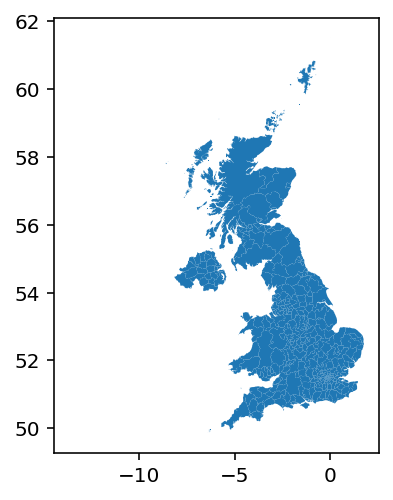

In [3]:
gbr.plot()

In [4]:
gbr.head()

,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,NL_NAME_2,GID_3,NAME_3,VARNAME_3,NL_NAME_3,TYPE_3,ENGTYPE_3,CC_3,HASC_3,geometry
0,GBR,United Kingdom,GBR.1_1,England,None,GBR.1.1_1,Barnsley,None,GBR.1.1.1_1,Barnsley,None,None,Metropolitan borough,Metropolitan borough,None,GB.BX.BX,"MULTIPOLYGON (((-1.78997 53.47293, -1.79306 53..."
1,GBR,United Kingdom,GBR.1_1,England,None,GBR.1.2_1,Bath and North East Somerset,None,GBR.1.2.1_1,Bath and North East Somerset,None,None,Unitary authority,Unitary authority,None,GB.BN.BN,"MULTIPOLYGON (((-2.68629 51.31516, -2.68066 51..."
2,GBR,United Kingdom,GBR.1_1,England,None,GBR.1.3_1,Bedfordshire,None,GBR.1.3.1_1,Bedford,None,None,Unitary authority,Unitary authority,None,GB.FO.FO,"MULTIPOLYGON (((-0.58508 52.11364, -0.58806 52..."
3,GBR,United Kingdom,GBR.1_1,England,None,GBR.1.4_1,Birmingham,None,GBR.1.4.1_1,Birmingham,None,None,Metropolitan borough (city),Metropolitan borough (city),None,GB.BI.BI,"MULTIPOLYGON (((-1.73417 52.51014, -1.73984 52..."
4,GBR,United Kingdom,GBR.1_1,England,None,GBR.1.5_1,Blackburn with Darwen,None,GBR.1.5.1_1,Blackburn with Darwen,None,None,Unitary authority,Unitary authority,None,GB.BW.BW,"MULTIPOLYGON (((-2.51111 53.63377, -2.51317 53..."


## Extracting raster features

When performing spatial interpolation, for example by transferring population counts from one set of polygons to another, it is often useful to include additional data that constrains the estimation to areas that are known to be inhabited. A commonly-used data source in this regard is land use/land cover (LULC) data collected from from remote sensing and satellite imagery. But these data can also be difficult to work with because they're often distributed in large raster files that are difficult to process alongside polygonal vector data. To help processing, `tobler` provides the `extract_raster_features` function that consumes raster data and converts (a subset) of pixel values into polygon features represented by a geopandas GeoDataFrame.

As an example, consider [Copernicus](https://land.copernicus.eu/global/products/lc) which provides global, annual LULC data at a 100m pixel resolution. According to their [documentation](https://land.copernicus.eu/global/sites/cgls.vito.be/files/products/CGLOPS1_PUM_LC100m-V3_I3.3.pdf) "Urban / built up" areas are denoted with the value 50.

In the next cell we'll read in copernicus data from the web and extract all the urban cells from the raster

In [5]:
urban_gbr = extract_raster_features(gbr, 'https://s3-eu-west-1.amazonaws.com/vito.landcover.global/v3.0.1/2015/W020N60/W020N60_PROBAV_LC100_global_v3.0.1_2015-base_Discrete-Classification-map_EPSG-4326.tif', pixel_types=[50])

/Users/knaaptime/anaconda3/envs/tobler/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


The function returns a geodataframe with rows corresponding to regions of the input raster with contiguous pixels of the same cell value. Since we only extracted cells with value 50, every row in this geodataframe has the same value

In [6]:
urban_gbr.head()

,value,geometry
0,50.0,"POLYGON ((-1.24603 60.00000, -1.24603 59.99901..."
1,50.0,"POLYGON ((-1.25694 59.99802, -1.25694 59.99702..."
2,50.0,"POLYGON ((-1.24504 59.99702, -1.24504 59.99603..."
3,50.0,"POLYGON ((-1.22520 59.99702, -1.22520 59.99603..."
4,50.0,"POLYGON ((-1.24206 59.99008, -1.24206 59.98810..."


<AxesSubplot:>

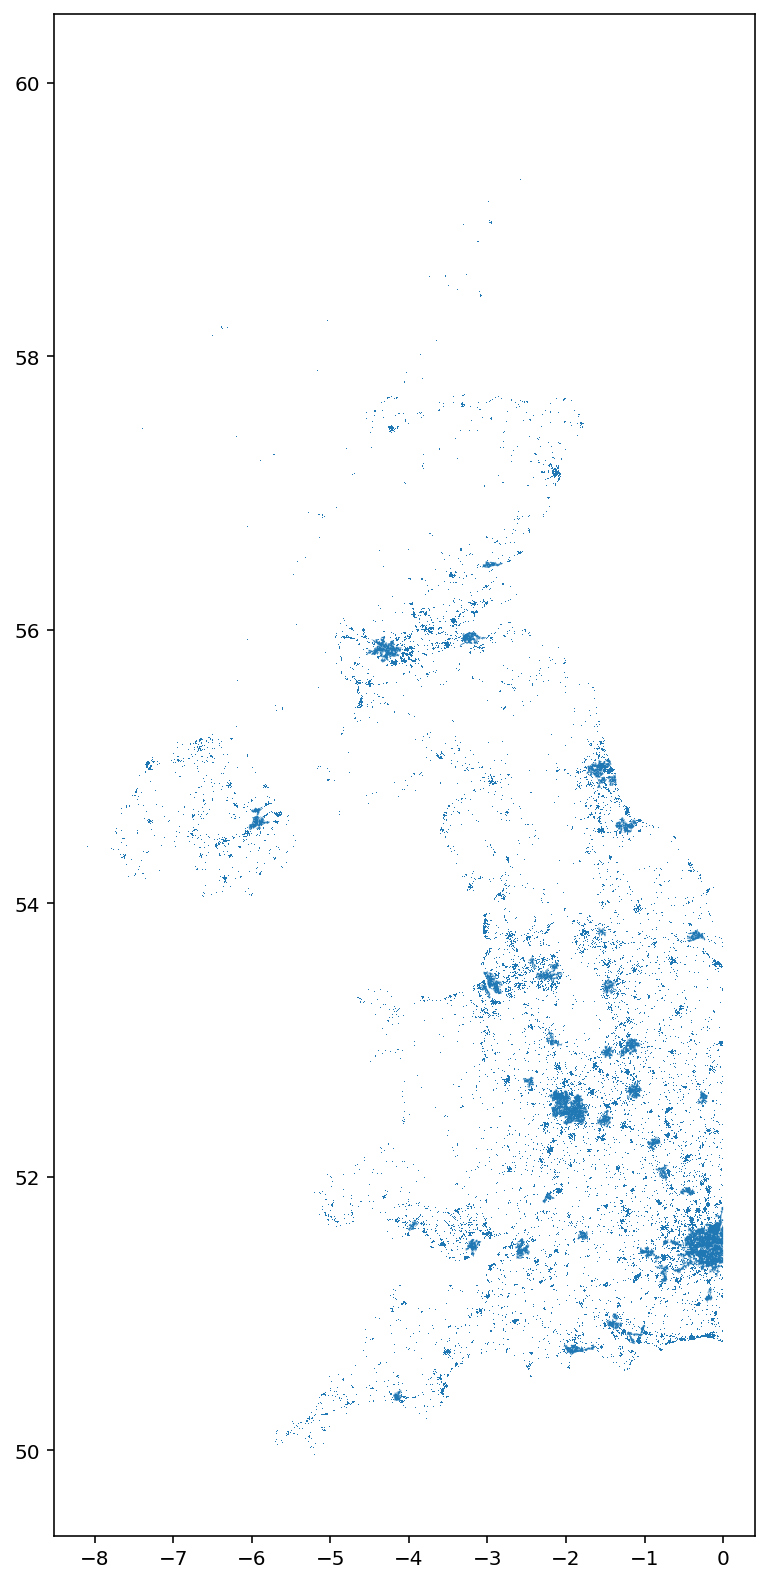

In [7]:
fig, ax = plt.subplots(figsize=(20,14))
urban_gbr.plot(ax=ax)

## Extracting development intensity

In addition to copernicus, other data sources may contain additional or more precise data. For example, the [National Land Cover Database]() (NLCD) provides land-use classification for the USA at a 30m pixel resolution. LULC classification in NLCD is also more detailed, with [four categories](https://www.mrlc.gov/data/legends/national-land-cover-database-2016-nlcd2016-legend) of developed land, with different cell values denoting different intensities

Here we'll use the `get_gadm` function to grab counties for the USA and take a look at urbanized areas in Los Angeles county.

In [8]:
usa = get_gadm('usa', 2)

In [9]:
la = usa[usa.NAME_2.str.lower().str.contains('los angeles')]

<AxesSubplot:>

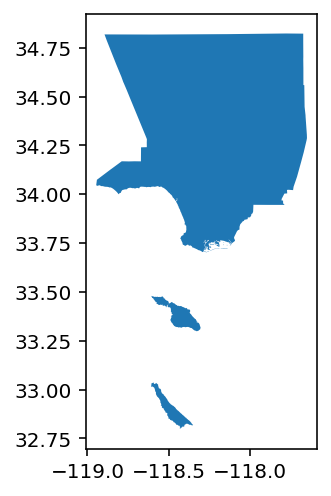

In [10]:
la.plot()

Now we'll call `extract_raster_features` again, but this time we'll read a compressed version of NLCD data from the [spatialucr](spatial.ucr.edu) quilt [bucket](https://open.quiltdata.com/b/spatial-ucr/packages/) and extract the values 21, 22, 23, and 24 which represent developed land of different intensities

In [11]:
urban_la = extract_raster_features(la, "s3://spatial-ucr/rasters/nlcd/nlcd_2011.tif", pixel_types=[21,22,23,24])

In [12]:
urban_la.head()

,value,geometry
0,22.0,"POLYGON ((-2057205.000 1555455.000, -2057205.0..."
1,23.0,"POLYGON ((-2057115.000 1555425.000, -2057115.0..."
2,22.0,"POLYGON ((-2057085.000 1555425.000, -2057085.0..."
3,21.0,"POLYGON ((-2057055.000 1555425.000, -2057055.0..."
4,22.0,"POLYGON ((-2057115.000 1555395.000, -2057115.0..."


Since we extracted multiple pixel types, the values in this geodataframe differ, and plotting the geodataframe reveals how development varies across LA county

In [13]:
urban_la = urban_la.to_crs(26945)

<AxesSubplot:>

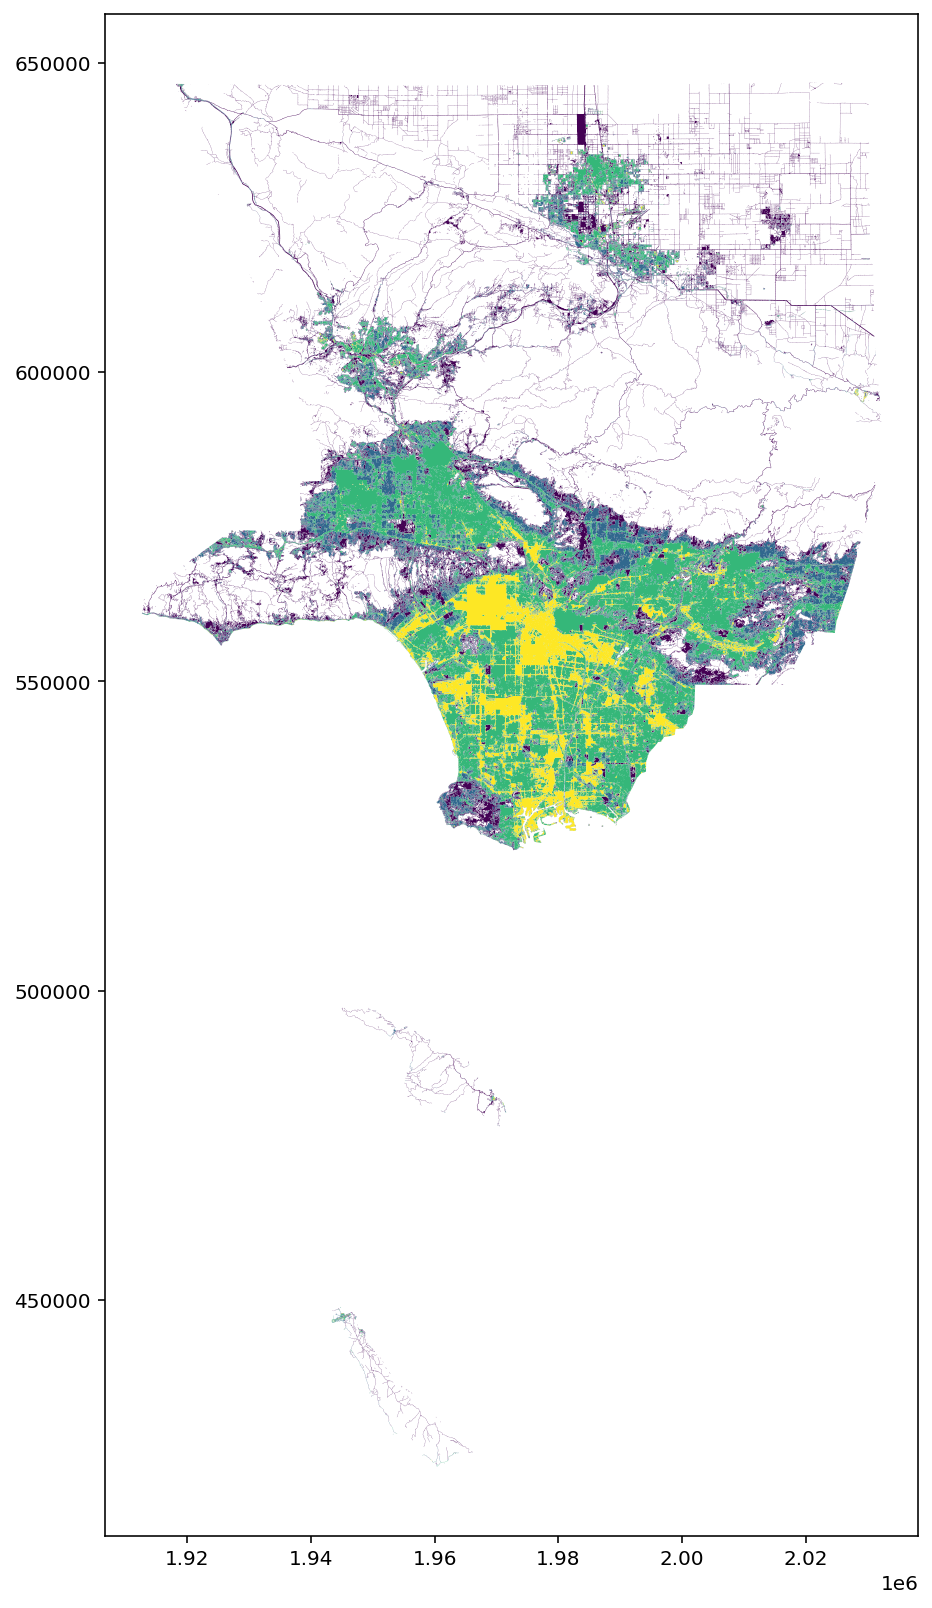

In [14]:
fig, ax = plt.subplots(figsize=(20,14))
urban_la.plot('value', ax=ax)

From here, these data can be used to clip source features prior to areal interpolation or used in additional data processing pipelines. Alternatively, we might have extracted water and forestry features we know *aren't* inhabited, and used the resulting features in reverse